In [36]:
import pandas as pd
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

queries = pd.read_csv('data/train_queries.csv', delimiter='\t')
docs = pd.read_json('data/docs.jsonl', lines=True)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/christianjensen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [37]:
queries['query_word_count'] = queries['text'].apply(lambda x: len(word_tokenize(x)))
docs['body_word_count'] = docs['body'].apply(lambda x: len(word_tokenize(x)))

print("Query length statistics:")
print(queries['query_word_count'].describe())

print("\nDocument length statistics:")
print(docs['body_word_count'].describe())

Query length statistics:
count    10000.000000
mean         6.045500
std          2.524731
min          1.000000
25%          4.000000
50%          6.000000
75%          7.000000
max         32.000000
Name: query_word_count, dtype: float64

Document length statistics:
count    200000.000000
mean       2138.348505
std        4093.288622
min           0.000000
25%         551.000000
50%        1037.000000
75%        2285.000000
max      413646.000000
Name: body_word_count, dtype: float64


In [32]:
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
print(queries['query_word_count'].quantile(percentiles))
print()
print(docs['body_word_count'].quantile(percentiles))

from scipy.stats import skew
print("Skew of query lengths:", skew(queries['query_word_count']))

0.10     3.0
0.25     4.0
0.50     6.0
0.75     7.0
0.90     9.0
0.95    11.0
Name: query_word_count, dtype: float64

0.10     283.0
0.25     551.0
0.50    1037.0
0.75    2285.0
0.90    4713.0
0.95    7366.0
Name: body_word_count, dtype: float64
Skew of query lengths: 1.3728262473577295


In [25]:
print("Empty queries:", (queries['query_word_count']==0).sum())
print("Docs > 10k words:", (docs['body_word_count']>1e4).sum())

Empty queries: 0
Docs > 10k words: 5888


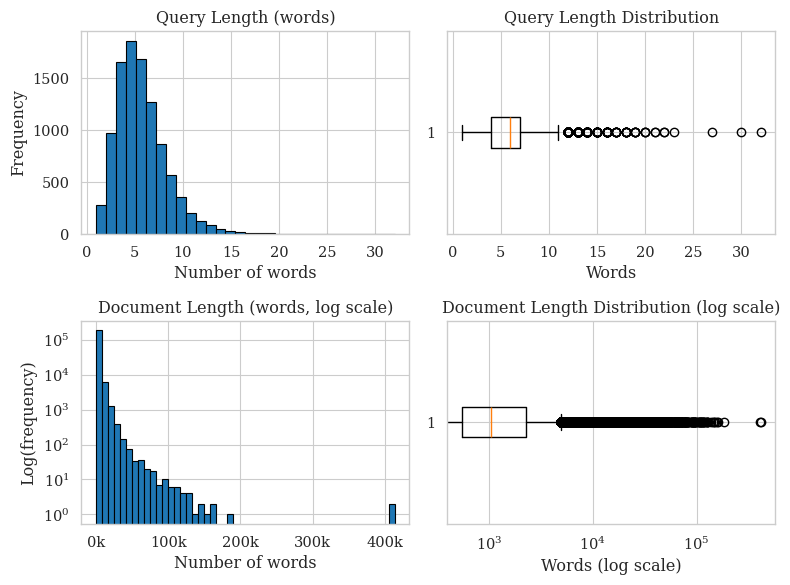

In [30]:
import matplotlib.pyplot as plt

# 1. Set a clean, serif style and larger fonts:
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.2)
plt.rc('font', family='serif')

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Query length histogram (words)
axes[0,0].hist(queries['query_word_count'], bins=30, edgecolor='black')
axes[0,0].set_title('Query Length (words)')
axes[0,0].set_xlabel('Number of words')
axes[0,0].set_ylabel('Frequency')

# Query boxplot
axes[0,1].boxplot(queries['query_word_count'], vert=False)
axes[0,1].set_title('Query Length Distribution')
axes[0,1].set_xlabel('Words')

# Document length histogram (log-y)
axes[1,0].hist(docs['body_word_count'], bins=50, edgecolor='black')
axes[1,0].set_yscale('log')
axes[1,0].set_title('Document Length (words, log scale)')
axes[1,0].set_xlabel('Number of words')
axes[1,0].set_ylabel('Log(frequency)')
axes[1,0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

# Document boxplot
axes[1,1].boxplot(docs['body_word_count'], vert=False)
axes[1,1].set_title('Document Length Distribution (log scale)')
axes[1,1].set_xlabel('Words (log scale)')
axes[1,1].set_xscale('log')

plt.tight_layout()
plt.show()

In [40]:
from collections import Counter
from nltk.tokenize import word_tokenize

# 1. Tokenize & normalize
tokens = [
    tok.lower()
    for text in queries['text'].astype(str)
    for tok in word_tokenize(text)
    if tok.isalpha()
]

# 2. Count & get top 20
freq = Counter(tokens)
top_20 = freq.most_common(20)

print("Top 20 words:")
for word, count in top_20:
    print(f"{word}: {count}")

Top 20 words:
what: 4060
is: 3549
the: 2004
a: 1547
of: 1508
how: 1469
in: 1292
to: 956
does: 884
for: 823
do: 591
are: 563
where: 446
definition: 440
long: 399
when: 371
can: 363
who: 356
and: 328
you: 327


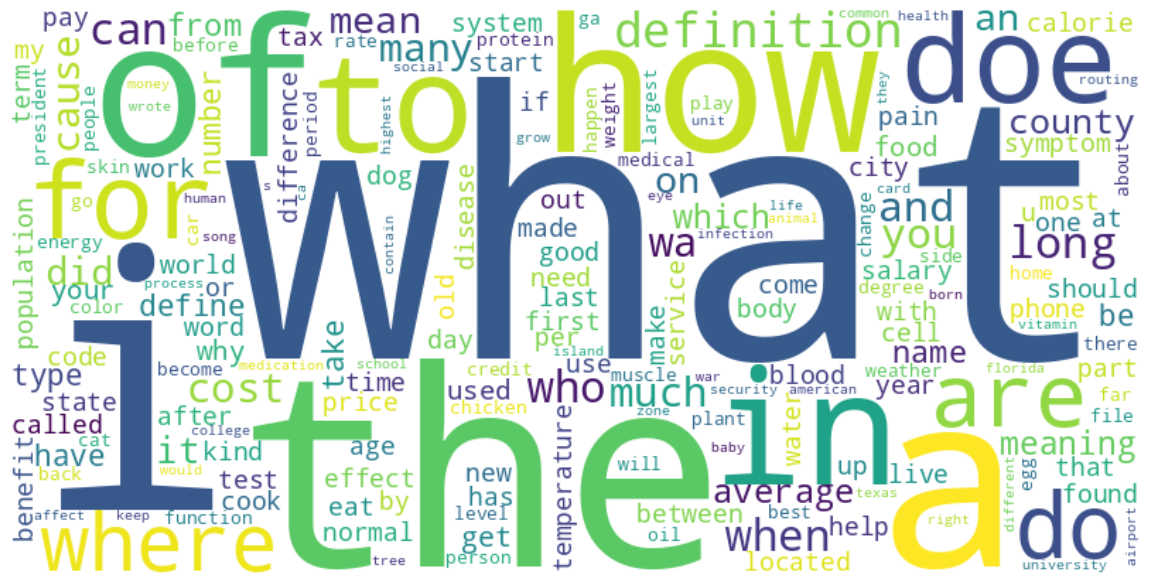

In [41]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# 3. Combine all query texts into one big string
all_text = " ".join(queries['text'].astype(str))

# 4. (Optional) Define extra stopwords
stopwords = set(STOPWORDS)
# e.g. stopwords.update(["please","help","google"])  # whatever common words you want to ignore

# 5. Generate the word cloud
wc = WordCloud(
    width=800, 
    height=400,
    background_color='white',
    stopwords=set(),
    max_words=200,
    collocations=False  # don’t join bigrams, just single words
).generate(all_text)

# 6. Display it
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()